<a href="https://colab.research.google.com/github/fahadrafiq94/Deep-Learning/blob/main/Step_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Helper Functions

In [ ]:
from helper_functions import data_preperation, cnn_train_entropy, cnn_train_focal, mlp_train

# Import Library

In [ ]:
import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms

import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.utils import resample
import torch.nn.functional as F

## Reading Data

In [ ]:
path = '/content/drive/MyDrive/final_project/Kaggle competition dataset/data'
combined_df = data_preperation(path)

In [ ]:
combined_df

,Activity,AccelX_5,AccelY_5,AccelZ_5,GyroX_5,GyroY_5,GyroZ_5,step
0,0,0.148915,4.705827,8.557376,-0.013430,-0.001028,0.017995,0.0
1,0,0.202848,4.666829,8.485154,-0.027897,-0.000346,0.016360,0.0
2,0,0.232652,4.668847,8.412815,-0.038700,0.023742,0.001388,0.0
3,0,0.194148,4.665260,8.463220,-0.049840,0.054852,-0.014097,0.0
4,0,0.118559,4.698190,8.585538,-0.061949,0.075178,-0.022977,0.0
...,...,...,...,...,...,...,...,...
722577,0,0.599268,2.624710,-9.532635,0.053674,-0.027126,0.004311,0.0
722578,0,0.632215,2.631344,-9.564042,0.056121,-0.012825,-0.003716,0.0
722579,0,0.612604,2.675650,-9.590501,0.040939,-0.016002,-0.006703,0.0
722580,0,0.603940,2.653812,-9.593956,0.016346,-0.025056,-0.013025,0.0


In [ ]:
print(combined_df.columns)

Index([' Activity', ' AccelX_5', ' AccelY_5', ' AccelZ_5', ' GyroX_5',
       ' GyroY_5', ' GyroZ_5', 'step'],
      dtype='object')


In [ ]:
# Remove leading/trailing spaces from column names
combined_df.columns = combined_df.columns.str.strip()

In [ ]:
combined_df['step'].value_counts()

0.0    709740
1.0      6421
2.0      6421
Name: step, dtype: int64

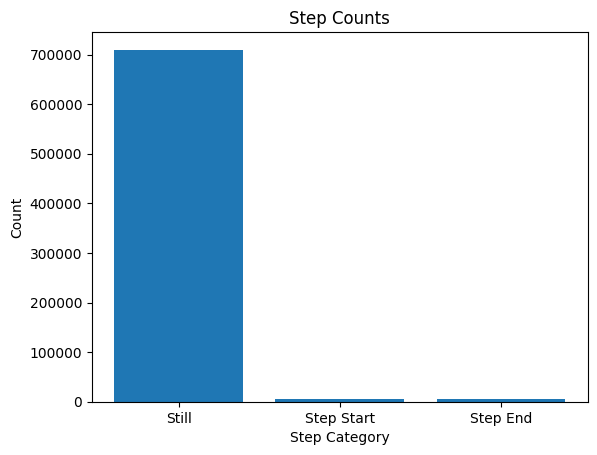

In [ ]:
# Assuming your dataframe is named 'df'
steps = combined_df.iloc[:, -1]  # Extract the steps column (last column)

# Map step category codes to English names
step_names = {0: 'Still', 1: 'Step Start', 2: 'Step End'}
steps = steps.map(step_names)

# Count the occurrences of each step category
step_counts = steps.value_counts()

# Plotting the bar graph
plt.bar(step_counts.index, step_counts.values)
plt.xlabel('Step Category')
plt.ylabel('Count')
plt.title('Step Counts')
plt.show()


## Preprocessing

In [ ]:
# Ensuring that there is no nan values in the dataset
combined_df = combined_df.dropna()

In [ ]:
combined_df

,Activity,AccelX_5,AccelY_5,AccelZ_5,GyroX_5,GyroY_5,GyroZ_5,step
0,0,0.148915,4.705827,8.557376,-0.013430,-0.001028,0.017995,0.0
1,0,0.202848,4.666829,8.485154,-0.027897,-0.000346,0.016360,0.0
2,0,0.232652,4.668847,8.412815,-0.038700,0.023742,0.001388,0.0
3,0,0.194148,4.665260,8.463220,-0.049840,0.054852,-0.014097,0.0
4,0,0.118559,4.698190,8.585538,-0.061949,0.075178,-0.022977,0.0
...,...,...,...,...,...,...,...,...
722577,0,0.599268,2.624710,-9.532635,0.053674,-0.027126,0.004311,0.0
722578,0,0.632215,2.631344,-9.564042,0.056121,-0.012825,-0.003716,0.0
722579,0,0.612604,2.675650,-9.590501,0.040939,-0.016002,-0.006703,0.0
722580,0,0.603940,2.653812,-9.593956,0.016346,-0.025056,-0.013025,0.0


In [ ]:
combined_df["step"].value_counts()

0.0    709740
1.0      6421
2.0      6421
Name: step, dtype: int64

### Normalization

In [ ]:
# Assuming your dataframe is named 'combined_df'
output_column = combined_df.iloc[:, -1]  # Extract the last column (output variable)

# Normalize all columns except the last one
numerator = (combined_df.iloc[:, :-1] - combined_df.iloc[:, :-1].min())
denominator = (combined_df.iloc[:, :-1].max() - combined_df.iloc[:, :-1].min())
df_normalized =  numerator / denominator

# Concatenate the normalized data and the output column
df_normalized = pd.concat([df_normalized, output_column], axis=1)


In [ ]:
df_normalized["step"].value_counts()

0.0    709740
1.0      6421
2.0      6421
Name: step, dtype: int64

In [ ]:
# Convert DataFrame to numpy array
# data = combined_df.values
data = df_normalized.values

# Split the data into input features (X) and labels (y)
X = data[:, 1:7]
y = data[:, -1]

## Train And test Split

In [ ]:
# Convert the data type of the numpy array elements
X = X.astype(np.float32)  # Convert input features to float32
y = y.astype(np.float32)

In [ ]:
# Split the data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Experiments

### Assign weights with crossentropy, CONV1D

tensor(567817) tensor(5106) tensor(5142)
tensor(0.9823) tensor(0.0088) tensor(0.0089)
Epoch: 0 | Loss: 0.22098, Accuracy: 91.41% | Test loss: 0.46868, Test acc: 90.36%
Epoch: 1 | Loss: 0.32113, Accuracy: 87.34% | Test loss: 0.64232, Test acc: 83.23%
Epoch: 2 | Loss: 0.28614, Accuracy: 86.50% | Test loss: 0.54480, Test acc: 84.43%
Epoch: 3 | Loss: 0.31536, Accuracy: 86.21% | Test loss: 0.50706, Test acc: 87.05%
Epoch: 4 | Loss: 0.43201, Accuracy: 85.91% | Test loss: 0.44731, Test acc: 88.94%
Train Accuracy: 85.91%
Test Accuracy: 88.94%


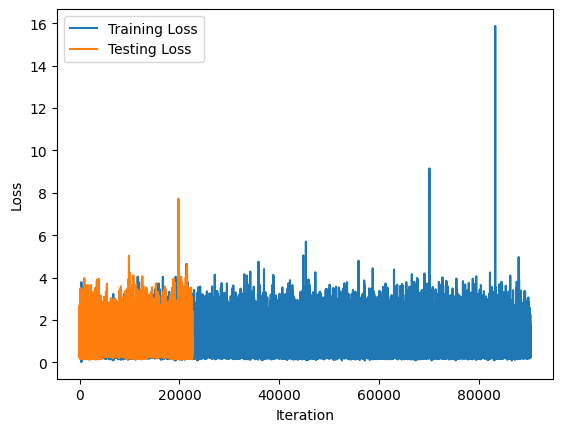

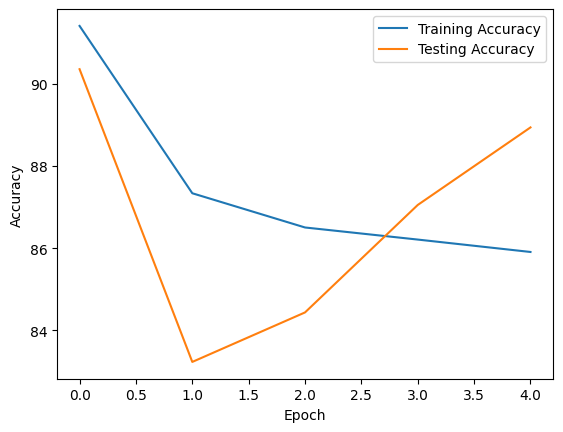

In [ ]:
# user paramters
out_channels = [128, 64, 32]  # list of hidden layer dimensions
epochs = 5 # number of epochs
batch_size = 32  # training batch size
learning_rate = 0.001  # learning rate
cuda = True  # true or false to train the model on cuda or not
plots = True
model_2 = cnn_train_entropy(train_data = X_train, train_label = y_train ,test_data = X_test, test_label = y_test, out_channels = out_channels, epochs = epochs,  batch_size = batch_size, learning_rate = learning_rate,cuda = cuda, plots = plots)


### Assign weights with focal loss, CONV1D

tensor(567817) tensor(5106)
tensor(0.9823) tensor(0.0088) tensor(0.0089)
Epoch: 0 | Loss: 0.12036, Accuracy: 91.23% | Test loss: 0.15022, Test acc: 89.65%
Epoch: 1 | Loss: 0.11484, Accuracy: 87.30% | Test loss: 0.19604, Test acc: 88.42%
Epoch: 2 | Loss: 0.10561, Accuracy: 86.64% | Test loss: 0.20879, Test acc: 86.81%
Epoch: 3 | Loss: 0.18490, Accuracy: 86.15% | Test loss: 0.21686, Test acc: 82.25%
Epoch: 4 | Loss: 0.22872, Accuracy: 86.39% | Test loss: 0.28971, Test acc: 73.80%
Train Accuracy: 86.39%
Test Accuracy: 73.80%


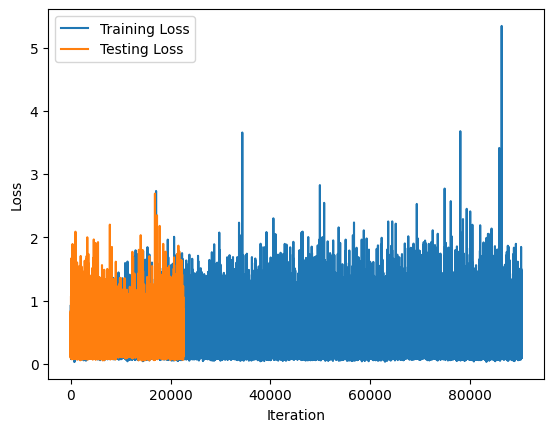

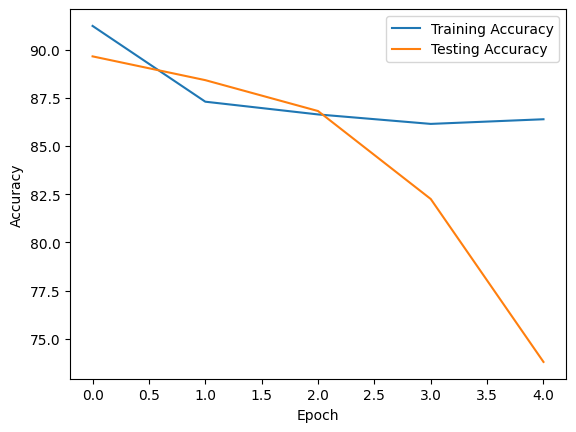

In [ ]:
# user paramters
out_channels = [128, 64, 32]  # list of hidden layer dimensions
epochs = 5 # number of epochs
batch_size = 32  # training batch size
learning_rate = 0.001  # learning rate
cuda = True  # true or false to train the model on cuda or not
plots = True
model_3 = cnn_train_focal(train_data = X_train, train_label = y_train ,test_data = X_test, test_label = y_test, out_channels = out_channels, epochs = epochs,  batch_size = batch_size, learning_rate = learning_rate,cuda = cuda, plots = plots)


### Assign weights with crossentropy, LinModel

tensor(567817) tensor(5106)
tensor(0.9823) tensor(0.0088) tensor(0.0089)
Epoch: 0 | Loss: 1.69758, Accuracy: 98.15% | Test loss: 0.32788, Test acc: 98.21%
Epoch: 1 | Loss: 1.35116, Accuracy: 98.19% | Test loss: 0.45509, Test acc: 98.21%
Epoch: 2 | Loss: 2.45714, Accuracy: 98.05% | Test loss: 0.59615, Test acc: 98.21%
Epoch: 3 | Loss: 0.38080, Accuracy: 97.81% | Test loss: 0.45664, Test acc: 98.21%
Epoch: 4 | Loss: 0.32638, Accuracy: 97.25% | Test loss: 0.30205, Test acc: 98.21%
Train Accuracy: [98.14951605788276, 98.18705508896059, 98.04883533858649, 97.8137406693019, 97.24633042996895]%
Test Accuracy: [98.20505546060325, 98.20505546060325, 98.20505546060325, 98.20505546060325, 98.20505546060325]%


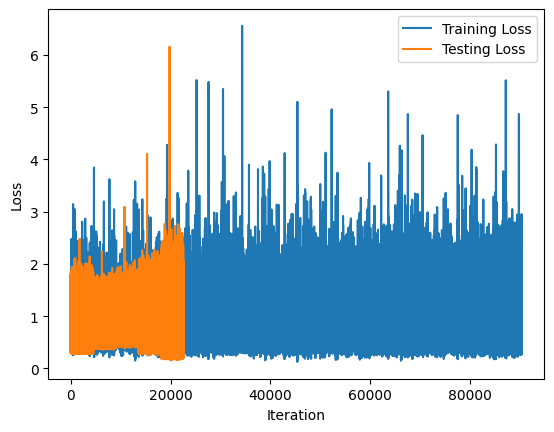

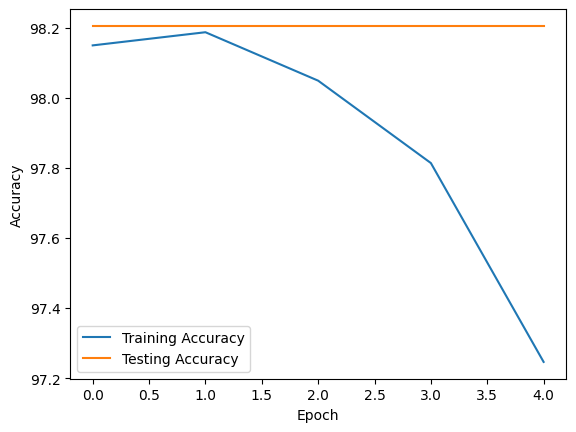

In [ ]:
# user paramters
hidden_dims = [128, 64, 32]  # list of hidden layer dimensions
epochs = 5 # number of epochs
batch_size = 32  # training batch size
learning_rate = 0.001  # learning rate
cuda = True  # true or false to train the model on cuda or not
plots = True
model_1 = mlp_train(train_data = X_train, train_label = y_train ,test_data = X_test, test_label = y_test, hidden_dims= hidden_dims, epochs = epochs,  batch_size = batch_size, learning_rate = learning_rate,cuda = cuda, plots = plots)


## Test Data

In [ ]:
test_df = pd.read_csv("/content/drive/MyDrive/final_project/Kaggle competition dataset/data/testdata.csv")


In [ ]:
# Train values are used to normal the test data
test_df_norm = numerator / denominator

In [ ]:
test_data  = test_df_norm.values
test_data = torch.Tensor(test_data)

In [ ]:
def get_prediction(model, data):
  # Make predictions
  # Check if CUDA is available and set device accordingly
  device = torch.device("cuda" if cuda and torch.cuda.is_available() else "cpu")
  model.eval()
  with torch.inference_mode():
    data = data.unsqueeze(1)
    y_logits = model(data.to(device))
    # Turn predicted logits in prediction probabilities
    y_pred_probs = torch.softmax(y_logits, dim=1)
    # Turn prediction probabilities into prediction labels
    y_preds = y_pred_probs.argmax(dim=1)
    # Compare first 10 model preds and test labels
    print(f"Predictions: {y_preds[:10]}")
    return y_preds

In [ ]:
def save_prediction(prediction, path):
  # Convert tensor to numpy array
  y_preds_array = prediction.cpu().numpy()
  # Create a dataframe
  save_df = pd.DataFrame({'y_preds': y_preds_array})
  print(save_df.value_counts())
  final_df = pd.DataFrame()
  final_df['start'] = np.where(save_df['y_preds'] == 1, 1, 0)
  final_df['end'] = np.where(save_df['y_preds'] == 2, 1, 0)
  final_df.to_csv(path)

In [ ]:
prediction_cnn_entropy = get_prediction(model_2, test_data)
prediction_cnn_focal = get_prediction(model_3, test_data)
prediction_mlp_entropy = get_prediction(model_1, test_data)

Predictions: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predictions: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predictions: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


In [ ]:
save_prediction(prediction_cnn_entropy, "/content/prediction_cnn_entropy.csv")
save_prediction(prediction_cnn_focal, "/content/prediction_cnn_focal_normalized.csv")
save_prediction(prediction_mlp_entropy, "/content/prediction_mlp_entropy_normalized.csv")

y_preds
0          100077
2            1762
1             252
dtype: int64
y_preds
0          88527
2           9848
1           3716
dtype: int64
y_preds
0          102091
dtype: int64
